In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
torch.cuda.device_count()

1

In [2]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

device = "cuda" if torch.cuda.is_available() else "cpu"

# get model
model = HookedTransformer.from_pretrained("google/gemma-2-2b", device = device)

layer = 15

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-att-canonical",
    sae_id = f"layer_{layer}/width_16k/canonical",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

Loading checkpoint shards: 100%|██████████| 3/3 [01:20<00:00, 26.75s/it]


Loaded pretrained model google/gemma-2-2b into HookedTransformer
blocks.15.attn.hook_z


In [6]:
from utils.testing import get_arc_easy_accuracy

accuracy, avg_logits_diff = get_arc_easy_accuracy(model, sae.cfg.context_size, batch_size=8, dataset_split="validation")

accuracy, avg_logits_diff

72it [02:03,  1.71s/it]


(0.7157894736842105, 2.3397375558551987)

In [4]:
from utils.get_steering_vector import get_steering_vectors_lr_and_mean_diff
from utils.dataset import get_tokenized_arc_easy_for_probing

res_layers_to_invade = [9, 10, 11, 13, 15]

tokenized_dataset = get_tokenized_arc_easy_for_probing(model=model, sae_context_size=sae.cfg.context_size,
                                                       dataset_split="train", batch_size=8, select_items=500)
Xs_difference_res, lrs_res, hook_names_res = get_steering_vectors_lr_and_mean_diff(model=model, layers_to_invade=res_layers_to_invade,
                                                                       device="cuda",
                                                                       tokenized_dataset=tokenized_dataset, batch_size=8, type_of_activation="res")

Filter: 100%|██████████| 500/500 [00:00<00:00, 27507.24 examples/s]


500 264


100%|██████████| 5/5 [03:55<00:00, 47.17s/it]


In [11]:
(Xs_difference_res[0] != 0).sum()

6851

In [15]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
import numpy as np

evaluated = []
for num_vectors in np.logspace(0, np.log10((Xs_difference_res[0] != 0).sum()), 10, base=10., dtype=int):
    steering_vectors_res = []
    for activation_vector, layer in zip(Xs_difference_res, res_layers_to_invade):
        sae, cfg_dict, _ = SAE.from_pretrained(
            release = "gemma-scope-2b-pt-res-canonical",
            sae_id = f"layer_{layer}/width_16k/canonical",
            device = device
        )
        features = np.argsort(-activation_vector)[:num_vectors]
        steering_vector = sum([sae.W_dec[feature] for feature in features])
        steering_vectors_res.append(steering_vector)
        break

    steering_strengths = [1. for _ in range(len(steering_vectors_res))]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names_res, sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=steering_vectors_res,
                steering_strengths=steering_strengths)
    print(num_vectors, res)
    evaluated.append(res)
evaluated

72it [00:49,  1.46it/s]


1 (0.7157894736842105, 2.340574190909402)


72it [00:58,  1.23it/s]


2 (0.7157894736842105, 2.341869985848142)


72it [01:26,  1.21s/it]


7 (0.7157894736842105, 2.3556804523133397)


72it [01:17,  1.08s/it]


18 (0.7140350877192982, 2.3288942822238856)


72it [01:12,  1.00s/it]


50 (0.7175438596491228, 2.362720637572439)


72it [01:19,  1.11s/it]


135 (0.7087719298245614, 2.3389503855454294)


72it [01:23,  1.16s/it]


360 (0.7052631578947368, 2.2011751292044655)


10it [00:10,  1.04s/it]


KeyboardInterrupt: 

In [26]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
import numpy as np

evaluated = []
for num_vectors in np.logspace(0, np.log10((Xs_difference_res[0] != 0).sum()), 10, base=10., dtype=int):
    steering_vectors_res = []
    for activation_vector, layer in zip(Xs_difference_res, res_layers_to_invade):
        sae, cfg_dict, _ = SAE.from_pretrained(
            release = "gemma-scope-2b-pt-res-canonical",
            sae_id = f"layer_{layer}/width_16k/canonical",
            device = device
        )
        features = np.argsort(-activation_vector)[:num_vectors]
        coefs = -np.sort(-activation_vector)[:num_vectors]
        steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, coefs)])
        steering_vectors_res.append(steering_vector)
        break

    steering_strengths = [1. for _ in range(len(steering_vectors_res))]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names_res, sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=steering_vectors_res,
                steering_strengths=steering_strengths)
    print(num_vectors, res)
    evaluated.append(res)
evaluated

72it [01:30,  1.26s/it]


1 (0.7157894736842105, 2.3397518559506065)


72it [01:44,  1.45s/it]


2 (0.7157894736842105, 2.341765213012695)


72it [01:28,  1.23s/it]


7 (0.7175438596491228, 2.352339526226646)


72it [01:40,  1.40s/it]


18 (0.7175438596491228, 2.338314894626015)


72it [01:36,  1.34s/it]


50 (0.7157894736842105, 2.350254943078024)


72it [01:18,  1.09s/it]


135 (0.7157894736842105, 2.3523469255681624)


72it [01:24,  1.18s/it]


360 (0.7157894736842105, 2.3512777211373312)


72it [01:11,  1.01it/s]


962 (0.7157894736842105, 2.359884862732469)


22it [00:21,  1.00it/s]


KeyboardInterrupt: 

In [38]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
import numpy as np

evaluated = []
for num_vectors in np.logspace(0, np.log10((lrs_res[0].coef_[0] != 0).sum()), 10, base=10., dtype=int):
    steering_vectors_res = []
    for lr, layer in zip(lrs_res, res_layers_to_invade):
        sae, cfg_dict, _ = SAE.from_pretrained(
            release = "gemma-scope-2b-pt-res-canonical",
            sae_id = f"layer_{layer}/width_16k/canonical",
            device = device
        )
        activation_vector = lr.coef_[0]
        features = np.argsort(-activation_vector)[:num_vectors]
        coefs = -np.sort(-activation_vector)[:num_vectors]
        steering_vector = sum([sae.W_dec[feature] for feature, coef in zip(features, coefs)])
        steering_vectors_res.append(steering_vector)
        break

    steering_strengths = [1. for _ in range(len(steering_vectors_res))]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names_res, sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=steering_vectors_res,
                steering_strengths=steering_strengths)
    print(num_vectors, res)
    evaluated.append(res)
evaluated

72it [01:30,  1.25s/it]


1 (0.7157894736842105, 2.340025303656595)


72it [01:28,  1.22s/it]


1 (0.7157894736842105, 2.340025303656595)


72it [01:13,  1.02s/it]


3 (0.7157894736842105, 2.320565094027603)


72it [01:04,  1.11it/s]


6 (0.7157894736842105, 2.327725556858799)


72it [00:59,  1.22it/s]


12 (0.7140350877192982, 2.338829636155513)


72it [00:56,  1.27it/s]


23 (0.7140350877192982, 2.3339776373746104)


72it [00:54,  1.32it/s]


44 (0.7157894736842105, 2.3637214267463014)


72it [00:50,  1.41it/s]


83 (0.7210526315789474, 2.3693369095785575)


72it [00:49,  1.47it/s]


156 (0.7157894736842105, 2.3228860528845536)


72it [00:49,  1.46it/s]

293 (0.7157894736842105, 2.243798519435682)


[(0.7157894736842105, 2.340025303656595),
 (0.7157894736842105, 2.340025303656595),
 (0.7157894736842105, 2.320565094027603),
 (0.7157894736842105, 2.327725556858799),
 (0.7140350877192982, 2.338829636155513),
 (0.7140350877192982, 2.3339776373746104),
 (0.7157894736842105, 2.3637214267463014),
 (0.7210526315789474, 2.3693369095785575),
 (0.7157894736842105, 2.3228860528845536),
 (0.7157894736842105, 2.243798519435682)]

In [37]:
# c = [accuracy] + [evaluated[-1][0] for _ in range(len(a) - 1)]

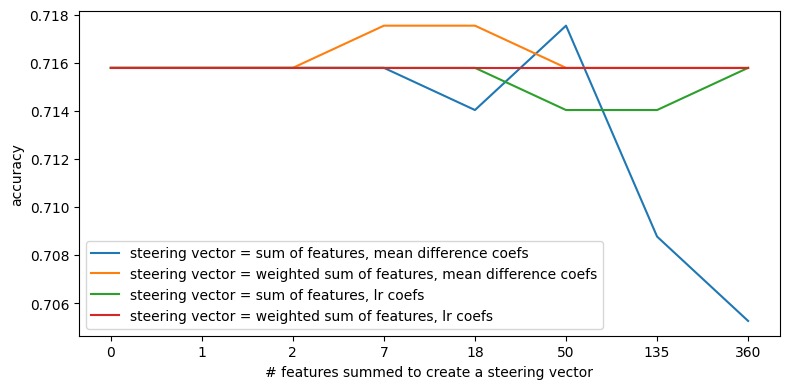

In [40]:
# a = [accuracy] + [e[0] for e in evaluated]
# b = [accuracy] + [e[0] for e in evaluated]
# b = b[:len(a)]
# c = [accuracy] + [evaluated[-1][0] for _ in range(len(a) - 1)]
d = [accuracy] + [e[0] for e in evaluated]
d = d[:len(a)]

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
fig.set_size_inches((8, 4))
axs.plot(a, label="steering vector = sum of features, mean difference coefs")
axs.plot(b, label="steering vector = weighted sum of features, mean difference coefs")
axs.plot(d, label="steering vector = sum of features, lr coefs")
axs.plot(c, label="steering vector = weighted sum of features, lr coefs")
axs.legend()
axs.set_xlabel("# features summed to create a steering vector")
axs.set_ylabel("accuracy")
labels = np.logspace(0, np.log10((Xs_difference_res[0] != 0).sum()), 10, base=10., dtype=int)[:len(a) - 1].tolist()

axs.set_xticks(np.arange(len(a)), labels=[0] + labels)
fig.tight_layout()
plt.savefig("sum_vs_weighted_sum.png")

In [ ]:
from torch.nn.functional import cosine_similarity

num_vectors = 10

cosine_similarities = np.zeros((len(res_layers_to_invade)))
for activation_vector, layer in zip(Xs_difference_res, res_layers_to_invade):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = np.argsort(-activation_vector)[:num_vectors]
    steering_vector = sum([sae.W_dec[feature] for feature in features])
    steering_vectors_res.append(steering_vector)
    break

cosine_similarity()